In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#### Clean the Data

In [3]:
# Load data

df_comments = pd.read_csv('../data/toxicity_annotated_comments.tsv', sep = '\t')
df_score = pd.read_csv('../data/toxicity_annotations.tsv', sep = '\t')

In [4]:
df_comments.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,2232.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train
1,4216.0,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,2002,True,user,random,train
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test
3,26547.0,`This is such a fun entry. DevotchkaNEWLINE_...,2002,True,article,random,train
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test


In [5]:
df_score.head()

,rev_id,worker_id,toxicity,toxicity_score
0,2232.0,723,0,0.0
1,2232.0,4000,0,0.0
2,2232.0,3989,0,1.0
3,2232.0,3341,0,0.0
4,2232.0,1574,0,1.0


In [6]:
# View size of the data frames

print(f'Comments data frame: {df_comments.shape}')
print(f'Score data frame: {df_score.shape}')

Comments data frame: (159686, 7)
Score data frame: (1598289, 4)


In [7]:
# Turn the rev_id columns into an int

df_comments['rev_id'] = df_comments['rev_id'].astype(int)
df_score['rev_id'] = df_score['rev_id'].astype(int)

In [8]:
# Take the average of toxicity and toxicity score for each rev id

df_score = df_score.groupby('rev_id').mean()

In [9]:
# Drop the worker id column

df_score.drop(columns = 'worker_id', inplace = True)

In [10]:
df_score.head()

,toxicity,toxicity_score
rev_id,,
2232,0.1,0.4
4216,0.0,0.5
8953,0.0,0.1
26547,0.0,0.6
28959,0.2,0.2


In [11]:
# Confirm the length of the scores table now matches the length of the comments table

print(f'Comments table: {df_comments.shape}')
print(f'Score table: {df_score.shape}')

Comments table: (159686, 7)
Score table: (159686, 2)


In [12]:
# Join the two dataframes into one table

df = pd.merge(df_comments, df_score, left_on = 'rev_id', right_on = 'rev_id', how = 'inner')

In [13]:
df.head()

,rev_id,comment,year,logged_in,ns,sample,split,toxicity,toxicity_score
0,2232,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train,0.1,0.4
1,4216,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,2002,True,user,random,train,0.0,0.5
2,8953,Elected or Electoral? JHK,2002,False,article,random,test,0.0,0.1
3,26547,`This is such a fun entry. DevotchkaNEWLINE_...,2002,True,article,random,train,0.0,0.6
4,28959,Please relate the ozone hole to increases in c...,2002,True,article,random,test,0.2,0.2


In [14]:
# Drop the extra columns: year, logged_in, ns, sample, split

df.drop(columns = ['year', 'logged_in', 'ns', 'sample', 'split'], inplace = True)

In [15]:
# Check for any null values

df.isnull().sum()

rev_id            0
comment           0
toxicity          0
toxicity_score    0
dtype: int64

In [16]:
# Confirm data types

df.dtypes

rev_id              int64
comment            object
toxicity          float64
toxicity_score    float64
dtype: object

In [17]:
# Remove NEWLINE_TOKEN from the comments field

df['comment'].replace('NEWLINE_TOKEN', '', regex = True, inplace = True)

#### Visualization of the Fields

In [18]:
# Create a column to store the length of the comments

comment_length = []

# For each comment capture the length in the new list
for i in range(0, df.shape[0]):
    length = len(df['comment'][i])
    comment_length.append(length)

# Assign the lengths to a new columns
df['comment_length'] = comment_length

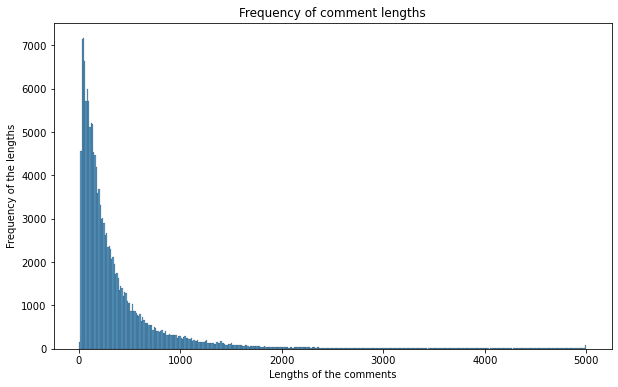

In [19]:
# View a histogram of the comment lengths

plt.figure(figsize = (10,6))
sns.histplot(df['comment_length'])
plt.title('Frequency of comment lengths')
plt.xlabel('Lengths of the comments')
plt.ylabel('Frequency of the lengths');

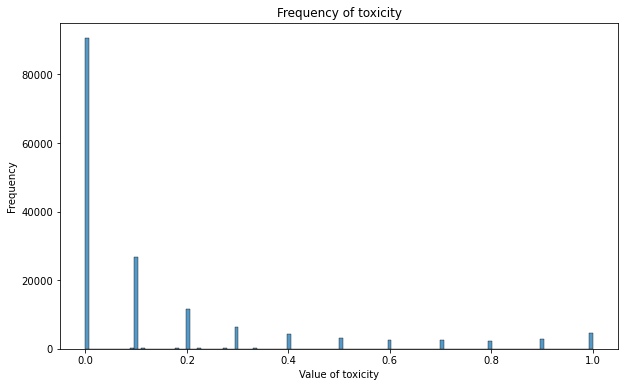

In [20]:
# View a histogram of the toxicity values

plt.figure(figsize = (10,6))
sns.histplot(df['toxicity'])
plt.title('Frequency of toxicity')
plt.xlabel('Value of toxicity')
plt.ylabel('Frequency');

In [21]:
# Map toxicity to be either 0 or 1 depending on if it's above or below 0.5

df['toxicity'] = (df['toxicity'] > 0.5).astype(int)
df['toxicity'].value_counts(normalize = True)

0    0.903799
1    0.096201
Name: toxicity, dtype: float64

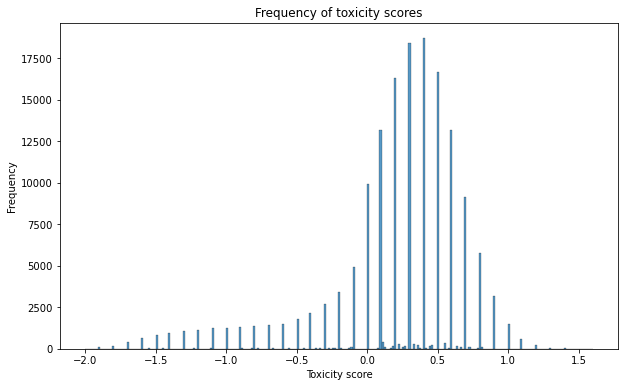

In [22]:
# View a histogram of the toxicity scores

plt.figure(figsize = (10,6))
sns.histplot(df['toxicity_score'])
plt.title('Frequency of toxicity scores')
plt.xlabel('Toxicity score')
plt.ylabel('Frequency');

#### Tokenize Comments

In [23]:
# Instantiate RegExp Tokenizer

tokenizer = RegexpTokenizer(r'\w+')

In [24]:
# Tokenize words

token_list = []

for i in range(0, df.shape[0]):
    tokens = tokenizer.tokenize(df['comment'][i])
    token_list.append(tokens)

In [25]:
token_list[0]

['This',
 'One',
 'can',
 'make',
 'an',
 'analogy',
 'in',
 'mathematical',
 'terms',
 'by',
 'envisioning',
 'the',
 'distribution',
 'of',
 'opinions',
 'in',
 'a',
 'population',
 'as',
 'a',
 'Gaussian',
 'curve',
 'We',
 'would',
 'then',
 'say',
 'that',
 'the',
 'consensus',
 'would',
 'be',
 'a',
 'statement',
 'that',
 'represents',
 'the',
 'range',
 'of',
 'opinions',
 'within',
 'perhaps',
 'three',
 'standard',
 'deviations',
 'of',
 'the',
 'mean',
 'opinion',
 'sounds',
 'arbitrary',
 'and',
 'ad',
 'hoc',
 'Does',
 'it',
 'really',
 'belong',
 'in',
 'n',
 'encyclopedia',
 'article',
 'I',
 'don',
 't',
 'see',
 'that',
 'it',
 'adds',
 'anything',
 'useful',
 'The',
 'paragraph',
 'that',
 'follows',
 'seems',
 'much',
 'more',
 'useful',
 'Are',
 'there',
 'any',
 'political',
 'theorists',
 'out',
 'there',
 'who',
 'can',
 'clarify',
 'the',
 'issues',
 'It',
 'seems',
 'to',
 'me',
 'that',
 'this',
 'is',
 'an',
 'issue',
 'that',
 'Locke',
 'Rousseau',
 'de',
 '

In [26]:
# Count the length of the words

list_words = []

for i in range (0, len(token_list)):
    temp_list = []
    for word in token_list[i]:
        temp_list.append(len(word))
    list_words.append(temp_list)
        

In [27]:
# Add the maximum word count for each comment

word_max = []

for i in range(0, df.shape[0]):
    max_count = max(list_words[i], default = 0)
    word_max.append(max_count)

df['max_count'] = word_max

In [28]:
# View the longest words

df[df['max_count'] > 1000]

,rev_id,comment,toxicity,toxicity_score,comment_length,max_count
49074,160842894,== Discussion destroying CRAP topic ==It seems...,1,-0.500000,4958,4702
49836,164347157,== ==U R GAY== ==FUCKFUCKFUCKFUCKFUCKFUCKFUCKF...,1,-1.900000,4972,4955
59017,194432946,== jerk me jolly ==fuckfuckfuckfuckfuckfuckfuc...,1,-2.000000,1852,1833
66215,218363956,shut up you cuntWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW...,1,-1.300000,4176,4164
84829,293236264,Small TextInsert non-formatted text here[[Medi...,0,0.000000,4472,1412
119443,459049021,== Gaaaaaaaaaaaaaaaaaaaaaaaaay! U r fucking ga...,1,-1.444444,4972,4920
124694,487872346,== Death To Wikipedia! Down with free Speach! ...,1,-0.700000,4972,4924
124695,487872381,== I shall purge this web site of the weak! ==...,1,-0.800000,4972,4926
124696,487872430,== Feel the might of Cyber Apocalypse! ==yyyyy...,0,0.000000,4972,4931
124697,487872506,== Your Web Site is As useless to the public a...,1,-0.900000,4972,4876


In [29]:
# Remove the comments with single words greater than 1000 characters

df = df[df['max_count'] < 1000]
df.reset_index(drop=True, inplace=True)

In [30]:
# Reset token list with words greater than 1000 characters removed

token_list = []

for i in range(0, df.shape[0]):
    tokens = tokenizer.tokenize(df['comment'][i])
    token_list.append(tokens)

#### Lemmatize Comments

In [31]:
# Instantiate lemmatizer

lemmatizer = WordNetLemmatizer()

In [32]:
# Lemmatize tokens

tokens_lem = []

for i in range(0, len(token_list)):
    token_temp = []
    for token in token_list[i]:
        tokens = lemmatizer.lemmatize(token)
        token_temp.append(tokens)
    tokens_lem.append(token_temp)

In [33]:
tokens_lem[0]

['This',
 'One',
 'can',
 'make',
 'an',
 'analogy',
 'in',
 'mathematical',
 'term',
 'by',
 'envisioning',
 'the',
 'distribution',
 'of',
 'opinion',
 'in',
 'a',
 'population',
 'a',
 'a',
 'Gaussian',
 'curve',
 'We',
 'would',
 'then',
 'say',
 'that',
 'the',
 'consensus',
 'would',
 'be',
 'a',
 'statement',
 'that',
 'represents',
 'the',
 'range',
 'of',
 'opinion',
 'within',
 'perhaps',
 'three',
 'standard',
 'deviation',
 'of',
 'the',
 'mean',
 'opinion',
 'sound',
 'arbitrary',
 'and',
 'ad',
 'hoc',
 'Does',
 'it',
 'really',
 'belong',
 'in',
 'n',
 'encyclopedia',
 'article',
 'I',
 'don',
 't',
 'see',
 'that',
 'it',
 'add',
 'anything',
 'useful',
 'The',
 'paragraph',
 'that',
 'follows',
 'seems',
 'much',
 'more',
 'useful',
 'Are',
 'there',
 'any',
 'political',
 'theorist',
 'out',
 'there',
 'who',
 'can',
 'clarify',
 'the',
 'issue',
 'It',
 'seems',
 'to',
 'me',
 'that',
 'this',
 'is',
 'an',
 'issue',
 'that',
 'Locke',
 'Rousseau',
 'de',
 'Toquevill

In [34]:
# Compare tokens to lemmatized version

first_term = list(zip(token_list[0], tokens_lem[0]))

In [35]:
# See which words the lemmatizer changed in first comment

[tup for tup in first_term if tup[0] != tup[1]]

[('terms', 'term'),
 ('opinions', 'opinion'),
 ('as', 'a'),
 ('opinions', 'opinion'),
 ('deviations', 'deviation'),
 ('sounds', 'sound'),
 ('adds', 'add'),
 ('theorists', 'theorist'),
 ('issues', 'issue')]

#### Stem Comments

In [36]:
# Instantiate PorterStemmer

p_stemmer = PorterStemmer()

In [37]:
# Stem tokens

tokens_stem = []

for i in range(0, len(token_list)):
    token_temp = []
    for token in token_list[i]:
        tokens = p_stemmer.stem(token)
        token_temp.append(tokens)
    tokens_stem.append(token_temp)

In [38]:
tokens_stem[0]

['thi',
 'one',
 'can',
 'make',
 'an',
 'analog',
 'in',
 'mathemat',
 'term',
 'by',
 'envis',
 'the',
 'distribut',
 'of',
 'opinion',
 'in',
 'a',
 'popul',
 'as',
 'a',
 'gaussian',
 'curv',
 'we',
 'would',
 'then',
 'say',
 'that',
 'the',
 'consensu',
 'would',
 'be',
 'a',
 'statement',
 'that',
 'repres',
 'the',
 'rang',
 'of',
 'opinion',
 'within',
 'perhap',
 'three',
 'standard',
 'deviat',
 'of',
 'the',
 'mean',
 'opinion',
 'sound',
 'arbitrari',
 'and',
 'ad',
 'hoc',
 'doe',
 'it',
 'realli',
 'belong',
 'in',
 'n',
 'encyclopedia',
 'articl',
 'i',
 'don',
 't',
 'see',
 'that',
 'it',
 'add',
 'anyth',
 'use',
 'the',
 'paragraph',
 'that',
 'follow',
 'seem',
 'much',
 'more',
 'use',
 'are',
 'there',
 'ani',
 'polit',
 'theorist',
 'out',
 'there',
 'who',
 'can',
 'clarifi',
 'the',
 'issu',
 'it',
 'seem',
 'to',
 'me',
 'that',
 'thi',
 'is',
 'an',
 'issu',
 'that',
 'lock',
 'rousseau',
 'de',
 'toquevil',
 'and',
 'other',
 'must',
 'have',
 'debat',
 'sr

In [39]:
# Compare tokens to stemmed version

first_term = list(zip(token_list[0], tokens_stem[0]))

In [40]:
# See which words the stemmer changed in first comment

[tup for tup in first_term if tup[0] != tup[1]]

[('This', 'thi'),
 ('One', 'one'),
 ('analogy', 'analog'),
 ('mathematical', 'mathemat'),
 ('terms', 'term'),
 ('envisioning', 'envis'),
 ('distribution', 'distribut'),
 ('opinions', 'opinion'),
 ('population', 'popul'),
 ('Gaussian', 'gaussian'),
 ('curve', 'curv'),
 ('We', 'we'),
 ('consensus', 'consensu'),
 ('represents', 'repres'),
 ('range', 'rang'),
 ('opinions', 'opinion'),
 ('perhaps', 'perhap'),
 ('deviations', 'deviat'),
 ('sounds', 'sound'),
 ('arbitrary', 'arbitrari'),
 ('Does', 'doe'),
 ('really', 'realli'),
 ('article', 'articl'),
 ('I', 'i'),
 ('adds', 'add'),
 ('anything', 'anyth'),
 ('useful', 'use'),
 ('The', 'the'),
 ('follows', 'follow'),
 ('seems', 'seem'),
 ('useful', 'use'),
 ('Are', 'are'),
 ('any', 'ani'),
 ('political', 'polit'),
 ('theorists', 'theorist'),
 ('clarify', 'clarifi'),
 ('issues', 'issu'),
 ('It', 'it'),
 ('seems', 'seem'),
 ('this', 'thi'),
 ('issue', 'issu'),
 ('Locke', 'lock'),
 ('Rousseau', 'rousseau'),
 ('Toqueville', 'toquevil'),
 ('others',

#### Vectorize Words

In [41]:
# Instantiate and fit the transformer

cvec = CountVectorizer(stop_words = 'english', token_pattern = r'\w+', strip_accents = 'ascii')

In [42]:
# Convert comments to dataframe to run vectorizer

X = df['comment']
X_df = pd.DataFrame(cvec.fit_transform(X).todense(), columns = cvec.get_feature_names())

In [43]:
X_df.head()

,0,00,000,0000,00000,000000,0000000,00000000,0000000027,00000001,...,zzzz,zzzzall,zzzzz,zzzzzzz,zzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
df[df['comment'].str.contains('zzzzzzzzzzzzzzzzzzzzzzzzzzzzzz')]

,rev_id,comment,toxicity,toxicity_score,comment_length,max_count
63871,209757656,Dont Change It!!!! zzzzzzzzzzzzzzzzzzzzzzzzzzz...,0,-0.375,5000,150
120420,464044185,Aargh - it's past 1 AM here and I need to be u...,1,-0.800,266,57
